## Lesson 8

In [1]:
import pandas as pd

In [2]:
filepath_dict = {
    'yelp': 'data/yelp_labelled.txt',
    'amazon': 'data/amazon_cells_labelled.txt',
    'imdb': 'data/imdb_labelled.txt'
}

df_list = []

for source, filepath in filepath_dict.items():
  df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
  df['source'] = source
  df_list.append(df)

df = pd.concat(df_list)

df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
labels = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25, random_state=1000)

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [6]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

In [7]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

In [10]:
import numpy as np 

In [11]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
  vocab_size = len(word_index) + 1
  embedding_matrix = np.zeros((vocab_size, embedding_dim))

  with open(filepath) as f:
    for line in f:
      word, *vector = line.split()
      if word in word_index:
        idx = word_index[word]
        embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

  return embedding_matrix 

In [12]:
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt', tokenizer.word_index, 50)

In [13]:
embedding_matrix.shape

(1747, 50)

In [14]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / (len(tokenizer.word_index) + 1)

0.9507727532913566

In [15]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [16]:
model = models.Sequential()
model.add(layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1, 
    output_dim=50, 
    input_length=100,
    weights=[embedding_matrix],
    trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    batch_size=10
)

Epoch 1/50
75/75 [==============================] - 0s 2ms/step - loss: 0.7112 - accuracy: 0.5280 - val_loss: 0.6958 - val_accuracy: 0.4880
Epoch 2/50
75/75 [==============================] - 0s 721us/step - loss: 0.6806 - accuracy: 0.5600 - val_loss: 0.6878 - val_accuracy: 0.5520
Epoch 3/50
75/75 [==============================] - 0s 726us/step - loss: 0.6700 - accuracy: 0.5960 - val_loss: 0.6814 - val_accuracy: 0.5560
Epoch 4/50
75/75 [==============================] - 0s 696us/step - loss: 0.6600 - accuracy: 0.6080 - val_loss: 0.6837 - val_accuracy: 0.5400
Epoch 5/50
75/75 [==============================] - 0s 687us/step - loss: 0.6556 - accuracy: 0.6040 - val_loss: 0.6764 - val_accuracy: 0.5880
Epoch 6/50
75/75 [==============================] - 0s 702us/step - loss: 0.6378 - accuracy: 0.6320 - val_loss: 0.6668 - val_accuracy: 0.5960
Epoch 7/50
75/75 [==============================] - 0s 725us/step - loss: 0.6251 - accuracy: 0.6533 - val_loss: 0.6592 - val_accuracy: 0.6120
Epoch 8/

In [18]:
_, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.4f}')
_, test_accuracy = model.evaluate(X_test, y_test)
print(f'Testing Accuracy: {test_accuracy:.4f}')

24/24 [==============================] - 0s 796us/step - loss: 0.4630 - accuracy: 0.7773
Training Accuracy: 0.7773
8/8 [==============================] - 0s 776us/step - loss: 0.5935 - accuracy: 0.7200
Testing Accuracy: 0.7200


In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [20]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

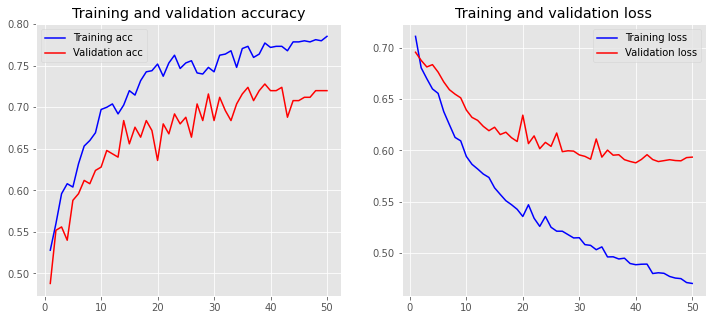

In [21]:
plot_history(history)

In [22]:
model = models.Sequential()
model.add(layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1, 
    output_dim=50, 
    input_length=100,
    weights=[embedding_matrix],
    trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    batch_size=10
)



Epoch 1/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6970 - accuracy: 0.5893 - val_loss: 0.6684 - val_accuracy: 0.5880
Epoch 2/50
75/75 [==============================] - 0s 1ms/step - loss: 0.6428 - accuracy: 0.6680 - val_loss: 0.6564 - val_accuracy: 0.6320
Epoch 3/50
75/75 [==============================] - 0s 1ms/step - loss: 0.6096 - accuracy: 0.7320 - val_loss: 0.6351 - val_accuracy: 0.6360
Epoch 4/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5734 - accuracy: 0.7453 - val_loss: 0.6221 - val_accuracy: 0.6720
Epoch 5/50
75/75 [==============================] - 0s 1ms/step - loss: 0.5327 - accuracy: 0.8000 - val_loss: 0.6070 - val_accuracy: 0.6760
Epoch 6/50
75/75 [==============================] - 0s 1ms/step - loss: 0.4855 - accuracy: 0.8213 - val_loss: 0.5765 - val_accuracy: 0.7080
Epoch 7/50
75/75 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.8480 - val_loss: 0.5573 - val_accuracy: 0.7160
Epoch 8/50
75/75 [==

In [24]:
_, train_accuracy = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy:.4f}')
_, test_accuracy = model.evaluate(X_test, y_test)
print(f'Testing Accuracy: {test_accuracy:.4f}')


24/24 [==============================] - 0s 682us/step - loss: 0.0015 - accuracy: 1.0000
Training Accuracy: 1.0000
8/8 [==============================] - 0s 772us/step - loss: 0.6242 - accuracy: 0.7840
Testing Accuracy: 0.7840


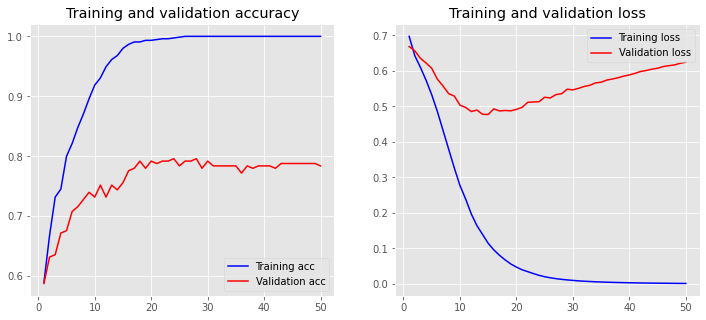

In [25]:
plot_history(history)